In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
vocab_size = 1000
embedding_dim = 32
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [51]:
with open('sarcasm.json', 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [52]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [53]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 32)            32000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 32,817
Trainable params: 32,817
Non-trainable params: 0
_________________________________________________________________


In [56]:
import numpy as np
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [57]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                   validation_data=(testing_padded, testing_labels_final), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.5058 - accuracy: 0.7469 - val_loss: 0.4033 - val_accuracy: 0.8077
Epoch 2/30
625/625 - 1s - loss: 0.3743 - accuracy: 0.8284 - val_loss: 0.3997 - val_accuracy: 0.8101
Epoch 3/30
625/625 - 1s - loss: 0.3624 - accuracy: 0.8366 - val_loss: 0.3999 - val_accuracy: 0.8116
Epoch 4/30
625/625 - 1s - loss: 0.3579 - accuracy: 0.8382 - val_loss: 0.4048 - val_accuracy: 0.8104
Epoch 5/30
625/625 - 1s - loss: 0.3544 - accuracy: 0.8392 - val_loss: 0.4038 - val_accuracy: 0.8114
Epoch 6/30
625/625 - 1s - loss: 0.3517 - accuracy: 0.8393 - val_loss: 0.4021 - val_accuracy: 0.8114
Epoch 7/30
625/625 - 1s - loss: 0.3482 - accuracy: 0.8413 - val_loss: 0.4078 - val_accuracy: 0.8137
Epoch 8/30
625/625 - 1s - loss: 0.3450 - accuracy: 0.8414 - val_loss: 0.3942 - val_accuracy: 0.8177
Epoch 9/30
625/625 - 2s - loss: 0.3392 - accuracy: 0.8450 - val_loss: 0.3935 - val_accuracy: 0.8177
Epoch 10/30
625/625 - 2s - loss: 0.3350 - accuracy: 0.8508 - val_loss: 0.3952 - val_accuracy: 0.8204

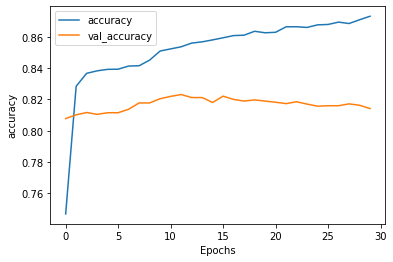

In [58]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show
    
plot_graphs(history, 'accuracy')


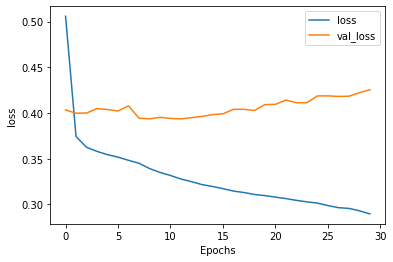

In [59]:
plot_graphs(history, 'loss')

In [61]:
#Get the index-word dictionary 
reverse_word_index = tokenizer.index_word

#Get the embedding layer from the model
embedding_layer = model.layers[0]

#Get the wegihts of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

#Print the shame.
print(embedding_weights.shape)

(1000, 32)


In [65]:
import io 

out_v = io.open('sarcasm.vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('sarcasm.meta.tsv', 'w', encoding='utf_8')

#Initialize the loop
for word_num in range(1, vocab_size):
    word_name = reverse_word_index[word_num]
    word_embedding = embedding_weights[word_num]
    
    out_m.write(word_name + '\n')
    out_v.write('\t'.join([str(x) for x in word_embedding]) + '\n')
    
out_m.close()
out_v.close()